<a href="https://colab.research.google.com/github/LeoMcBills/ML_humanEmotionDetection/blob/main/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q kaggle

In [2]:
# !mkdir ~/.kaggle

In [3]:
# !cp kaggle.json ~/.kaggle/

In [4]:
# !chmod 600 /root/.kaggle/kaggle.json

In [5]:
# !kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 96% 297M/309M [00:03<00:00, 166MB/s]
100% 309M/309M [00:04<00:00, 76.3MB/s]


In [6]:
# !unzip "/content/human-emotions-datasethes.zip" -d "/content/datasets"

Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/datasets/EmotionsD

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, RandomContrast, Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy,TopKCategoricalAccuracy, CategoricalAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import albumentations as A
import tensorflow_probability as tfp

In [8]:
train_directory = "/content/datasets/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [11]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

# Dataset Visualization

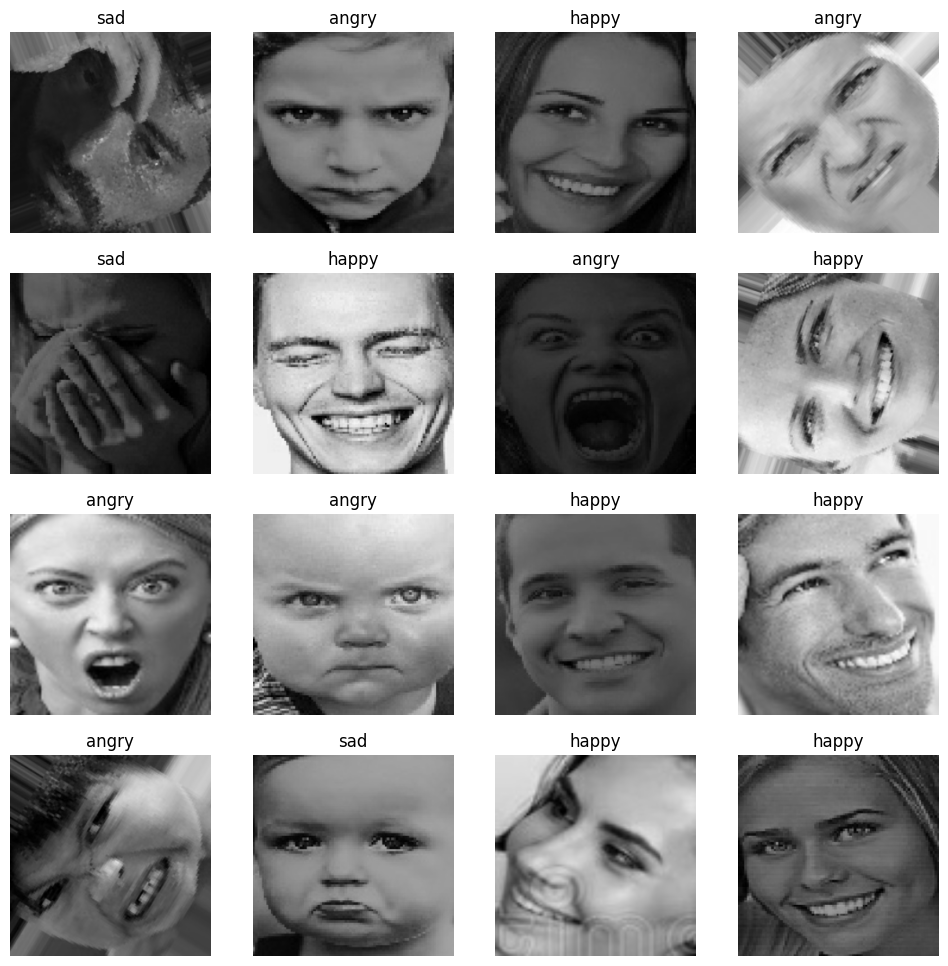

In [12]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# Data Augmentation

In [40]:
# tf.keras.layer augment

augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1),
])

In [41]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

cutmix augmentation

In [49]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [50]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

# DATA PREPARATION

In [51]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [52]:
training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [42]:
# training_dataset = (
#     train_dataset
#     .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [53]:
val_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [54]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

# Modeling

In [55]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 125, 125, 16)     

# Training

In [56]:
loss_function = CategoricalCrossentropy()
# loss_function = SparseCategoricalCrossentropy()

In [57]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

In [58]:
lenet_model.compile(
    optimizer = Adam(learning_rate= CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [59]:
history = lenet_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 110s 487ms/step - loss: 1.0469 - accuracy: 0.5026 - top_k_accuracy: 0.7895 - val_loss: 0.9584 - val_accuracy: 0.5666 - val_top_k_accuracy: 0.8250
Epoch 2/20
213/213 [==============================] - 103s 481ms/step - loss: 0.9433 - accuracy: 0.5695 - top_k_accuracy: 0.8366 - val_loss: 1.0114 - val_accuracy: 0.4823 - val_top_k_accuracy: 0.8156
Epoch 3/20
213/213 [==============================] - 104s 479ms/step - loss: 0.9040 - accuracy: 0.6070 - top_k_accuracy: 0.8566 - val_loss: 0.8783 - val_accuracy: 0.5916 - val_top_k_accuracy: 0.8357
Epoch 4/20
213/213 [==============================] - 103s 480ms/step - loss: 0.8715 - accuracy: 0.6347 - top_k_accuracy: 0.8672 - val_loss: 0.7353 - val_accuracy: 0.6897 - val_top_k_accuracy: 0.8975
Epoch 5/20
213/213 [==============================] - 103s 480ms/step - loss: 0.8496 - accuracy: 0.6438 - top_k_accuracy: 0.8712 - val_loss: 0.6891 - val_accuracy: 0.7295 - val_top_k_accuracy: 0.9085


# Visualization


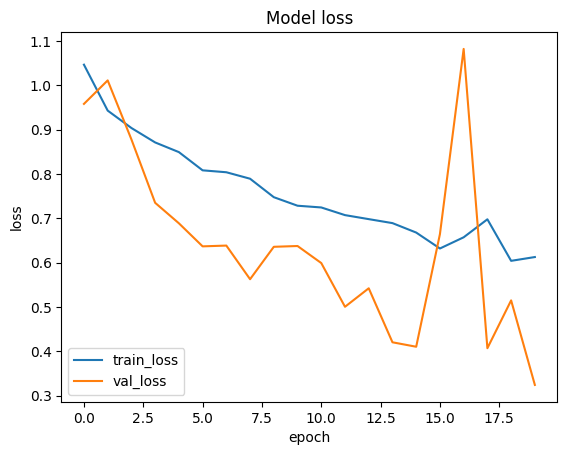

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [61]:
print(history.history)

{'loss': [1.0468761920928955, 0.943303644657135, 0.9040335416793823, 0.8714519739151001, 0.849645733833313, 0.80852210521698, 0.8041895031929016, 0.7895911931991577, 0.747941792011261, 0.7286810278892517, 0.7247642278671265, 0.7074817419052124, 0.6984322667121887, 0.6894285678863525, 0.6681252121925354, 0.6321768760681152, 0.6574456095695496, 0.6980489492416382, 0.6043335199356079, 0.6128840446472168], 'accuracy': [0.5025739073753357, 0.5694954991340637, 0.607001006603241, 0.6346521377563477, 0.6437711715698242, 0.6753934621810913, 0.6886307001113892, 0.6914252042770386, 0.7254008054733276, 0.7361376881599426, 0.735990583896637, 0.7458449602127075, 0.7595234513282776, 0.7556993961334229, 0.7808501124382019, 0.7901161909103394, 0.7873216867446899, 0.767024576663971, 0.8027651309967041, 0.8126195073127747], 'top_k_accuracy': [0.7895278930664062, 0.8365936279296875, 0.8565965294837952, 0.8671863675117493, 0.8711575269699097, 0.8879246711730957, 0.8955729007720947, 0.9041035175323486, 0.90

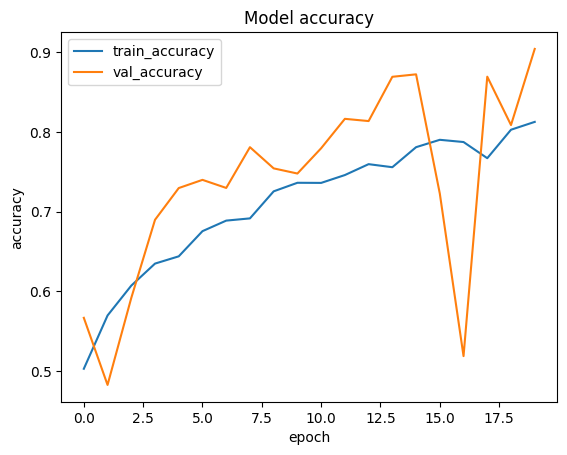

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model evaluation

In [63]:
lenet_model.evaluate(val_dataset)

213/213 [==============================] - 8s 37ms/step - loss: 0.3244 - accuracy: 0.9043 - top_k_accuracy: 0.9801


[0.3243820369243622, 0.9042506217956543, 0.9801441431045532]

# Testing

In [64]:
# test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/105639.jpg")

# im = tf.constant(test_image, dtype = tf.float32)

# im = tf.expand_dims(im, axis = 0)

# print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

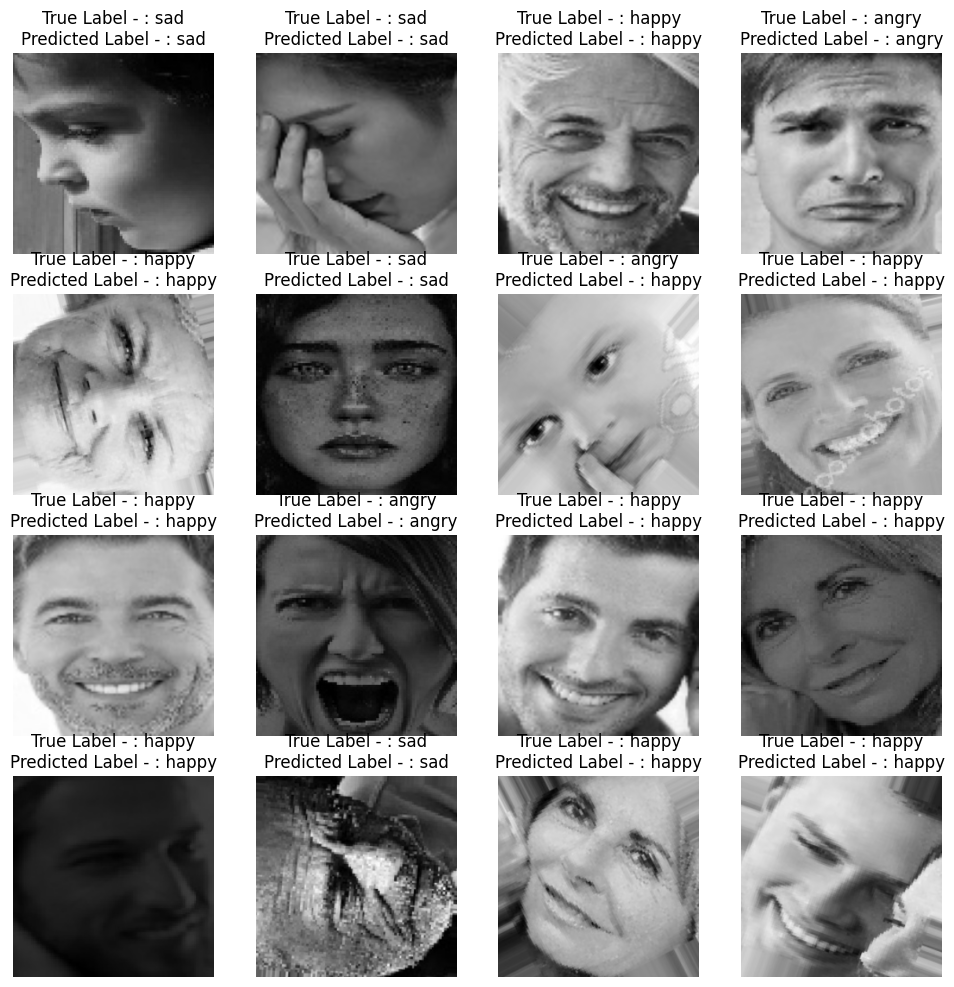

In [65]:
plt.figure(figsize = (12, 12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]
              + "\n" + "Predicted Label - : "
              + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]])
    plt.axis("off")

# Confusion Matrix

In [66]:
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [67]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]


In [68]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[1246  146  133]
 [  25 2892  102]
 [  61  184 2010]]


Text(0.5, 58.7222222222222, 'Predicted')

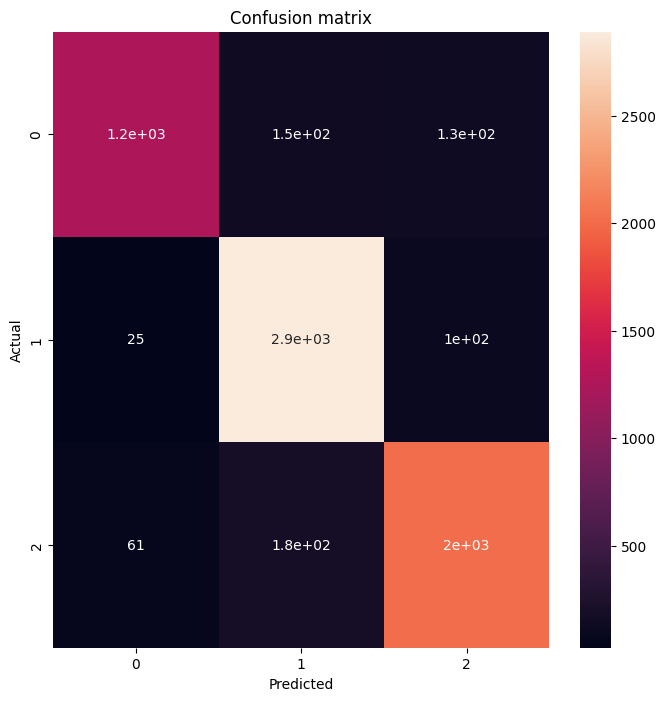

In [69]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize = (8, 8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')